# detectron2 for まちカドまぞく ～カスタム評価編～

<img src="https://user-images.githubusercontent.com/33882378/79108398-34fe8400-7db1-11ea-9b26-08e09e13243f.jpg">

detectron2 の推論部分をカスタマイズする方法です。今回はバッチ処理できるようにしました。

---

In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt

---
##  VoTT Export からの読み込み

In [2]:
# VoTT のエクスポートファイルや、画像が格納されているディレクトリ
BASE_DIRECTORY = './vott-json-export/'
# VoTT のエクスポートファイル名
EXPORT_FILENAME = 'Machikado-export.json'
# 訓練データに使用する割合
TRAIN_RATIO = 0.8
# 乱数シード
RANDOM_STATE = 0  # 訓練と同じにしておかないとズレちゃうよ！

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from machikado_util.Machikado_vott import get_cat_names, get_cat_color, get_machikado_dicts

# vott の読み込み関係は py ファイルにした
CAT_NAME2ID, CAT_ID2NAME = get_cat_names(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
dataset_dicts = get_machikado_dicts(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME), BASE_DIRECTORY, CAT_NAME2ID)

# VoTT のカテゴリの色も抽出する
CAT_IDS, CAT_COLORS = get_cat_color(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
CAT_IDS, CAT_COLORS

# 日本語表示を試す(CAT_ID2NAME と順番を一致させること！)
CAT_NAME_JP = ['シャミ子', 'ごせん像', 'リリス', 'もも', 'みかん', 'その他']
    
# 訓練用、テスト用に分ける
random.seed(RANDOM_STATE)
random.shuffle(dataset_dicts)

split_idx = int(len(dataset_dicts) * TRAIN_RATIO) + 1

# 登録
DatasetCatalog.clear()
DatasetCatalog.register('train', lambda : dataset_dicts[:split_idx])
DatasetCatalog.register('test', lambda : dataset_dicts[split_idx:])

# 日本語名はこっち
MetadataCatalog.get('train').set(thing_classes=CAT_NAME_JP)
MetadataCatalog.get('test').set(thing_classes=CAT_NAME_JP)

# VoTT のカテゴリ名はこっち
# MetadataCatalog.get('train').set(thing_classes=list(CAT_NAME2ID.keys()))
# MetadataCatalog.get('test').set(thing_classes=list(CAT_NAME2ID.keys()))

警告: name: 59.jpg - 画像サイズが不一致であるためスキップ image_size:(268, 201), ./vott-json-export/Machikado-export.json: (600, 600)


Metadata(name='test', thing_classes=['シャミ子', 'ごせん像', 'リリス', 'もも', 'みかん', 'その他'])

---
## 推論

プレディクタをカスタマイズして、バッチで推論します。

In [4]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.OUTPUT_DIR = './output'

# cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # ここの位置は ipynb ファイルの層泰一なので注意
# cfg.SOLVER.IMS_PER_BATCH = 2

cfg.merge_from_file('../configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 1 # GTX2070 ではこれが限界

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CAT_ID2NAME)  # machikado は6

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model

DefaultPredictor を継承するのが楽です。

> detectron2/engine/defaults.py を参照ください。

ポイントは・・・

* detectron メモリ食いすぎ！！
<p>GTX2070 程度では 6 程度しかバッチ処理できません。</p>
<p>まあ、実際に使う際には画像サイズ似合わせて cfg の設定を変えれば良いと思います。（デフォルトは MIN: 800, MAX: 1333 でリサイズしています）</p>

* あと、GPUメモリを消費しますので、都度 CPU に転送しないとすぐにメモリ不足になります。

このあたりを気をつければ OK です。

In [5]:
import torch
from detectron2.engine import DefaultPredictor

class MachikadoPredictor(DefaultPredictor):
    def __init__(self, cfg, batch_size=2):
        super().__init__(cfg)
        
        self.batch_size = batch_size
        
    def __call__(self, org_images):
        """
        original_images (np.ndarray list): [np.array[h, w, ch], np.array[h, w, ch], ・・・, np.array[h, w, ch]]
                                           画像ごとにサイズが違うのでこんな感じで
        """
        with torch.no_grad():
            inputs = []
            
            for img in org_images:
                height, width = img.shape[0:2]
                
                if self.input_format == "RGB":
                    img = img[:, :, ::-1]
                
                img = self.transform_gen.get_transform(img).apply_image(img)  # ResizeShortestEdge を呼んでいる
                img = img.astype('float32').transpose(2, 0, 1)
                img = torch.as_tensor(img)
                
                inputs.append({"image": img, "height": height, "width": width})
            
            predictions = []
            for i in range(0, len(inputs), self.batch_size):
                si = i
                ei = i + self.batch_size
                outputs = self.model(inputs[si:ei])
                
                for output in outputs:
                    output['instances'] = output['instances'].to('cpu') # ずーっと GPU においてはダメ！
                    
                predictions += outputs
                
        return predictions

バッチ処理の効果はあるのでしょうか？

In [6]:
# predictor = MachikadoPredictor(cfg, batch_size=2)

# inputs = []

# for asset in DatasetCatalog.get('test')[:10]:
#     img = cv2.imread(asset["file_name"])
#     inputs.append(img)

In [7]:
# %%timeit -n5 -r5
# outputs = predictor(inputs)

In [8]:
# predictor = MachikadoPredictor(cfg, batch_size=6)

In [9]:
# %%timeit -n5 -r5
# outputs = predictor(inputs)

あれ？　遅くなってないか？（笑）

> * あんまり効果が無いようですね。
> * 元からくそ重いですし、一度に前処理しているわけでもなく、実質ループを回しているのと変わらないんだと思います。
> * 後の方がお遅いのは GPU 温度が上がっているせいもあると思います。（動作クロックが下がっている）
> * まあ、小さな画像サイズで大量に処理するなら変わるのかもしれません。
> * 今回は、カスタマイズを試したかったので、目的は達成しているでしょう・・・

#### 推論結果の確認
さて、推論結果ですが、前回と比較してみると良くなっているように思うのですがどうでしょうか？

> mAP を計算した方がいいですね。

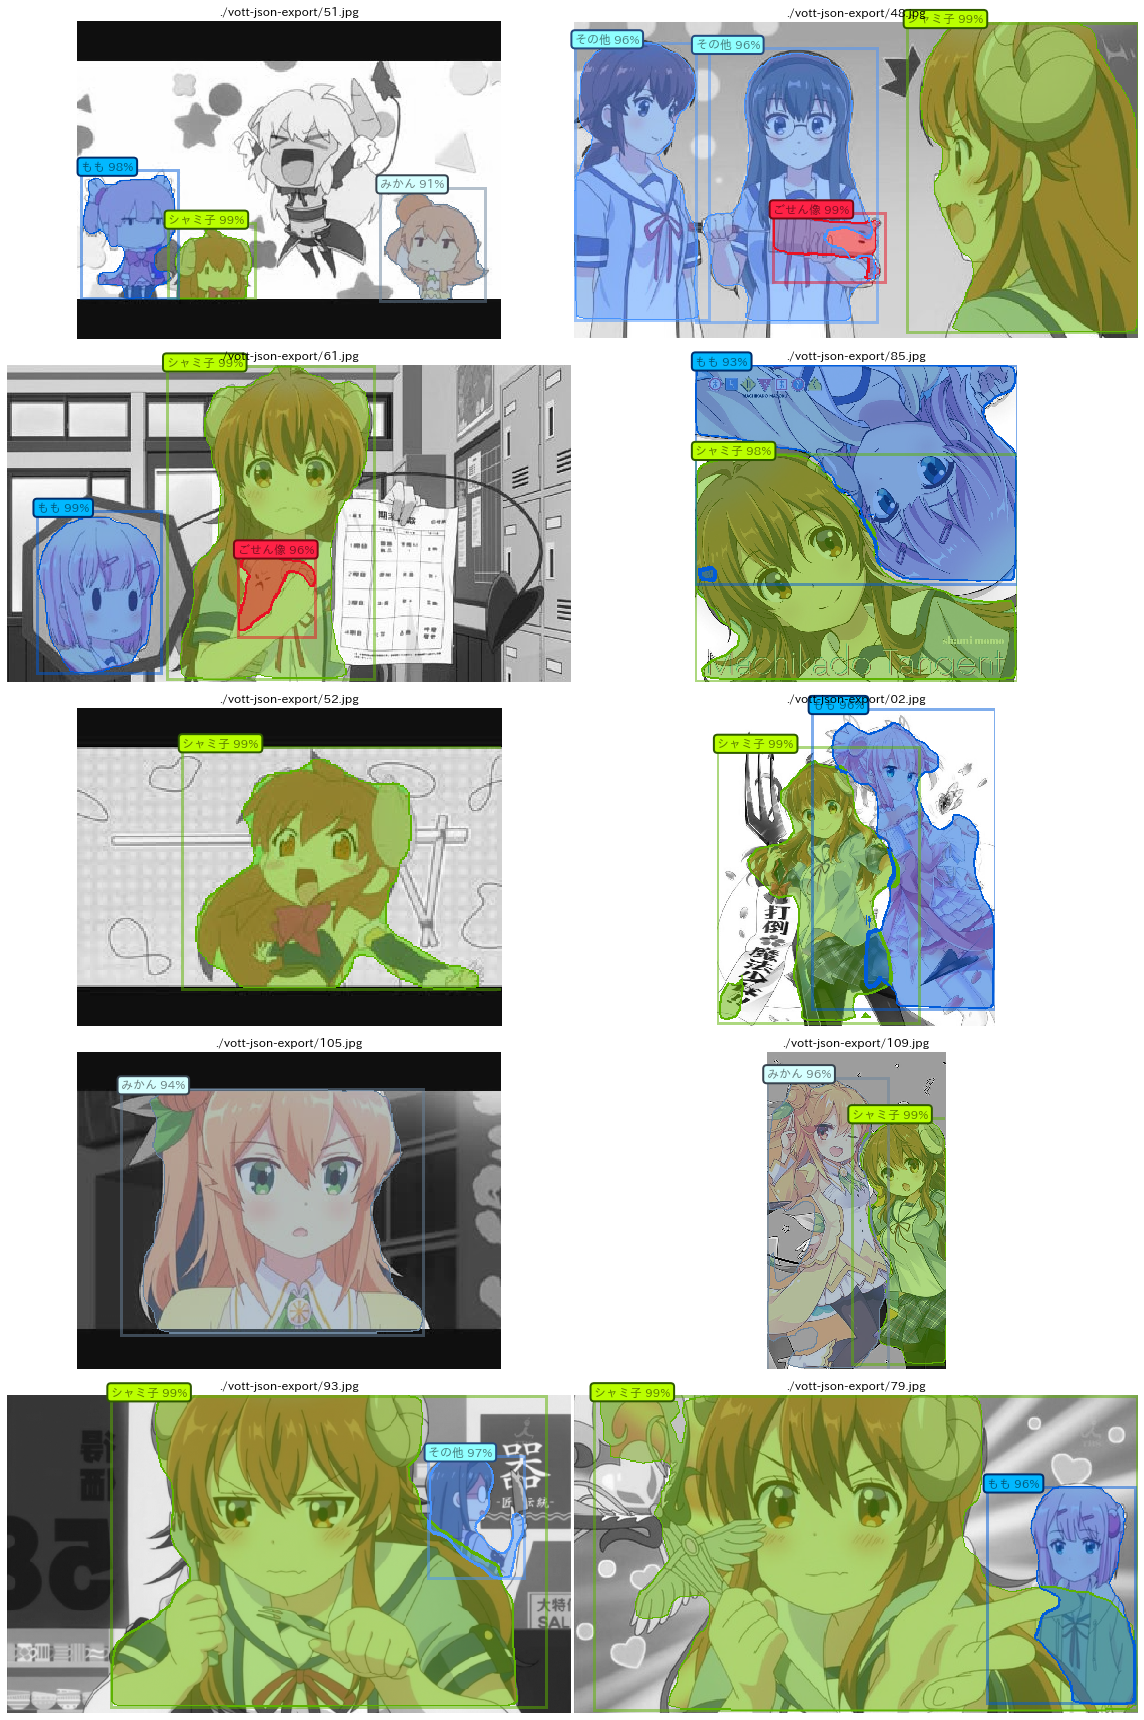

In [10]:
from machikado_util.plot_predictor2 import plot_predictor_batch

predictor = MachikadoPredictor(cfg, batch_size=4)
plot_predictor_batch(predictor=predictor, mask_colors=CAT_COLORS, cat_names=CAT_NAME_JP, catalog_name='test', random_state=None)

---
## 評価

AP を評価します。

In [11]:
from machikado_util.calc_ap import append_masks, get_true_datas, predict_datas_batch, make_info_dict

# データセットはテストを使用します
catalog_name='test'
# データセットにマスクデータを追加する
append_masks(dataset_dicts)

# 教師データから評価に必要な情報を取得する
true_dicts = get_true_datas(catalog_name=catalog_name)
# データセットを一度に推論して結果を取得する
pred_dicts = predict_datas_batch(predictor, catalog_name=catalog_name, verbose=False)
# precision, recall を計算する
df_dict = make_info_dict(true_dicts=true_dicts, pred_dicts=pred_dicts, classes=list(CAT_ID2NAME.keys()), th=0.5)

### PR(Precision-Recall)曲線

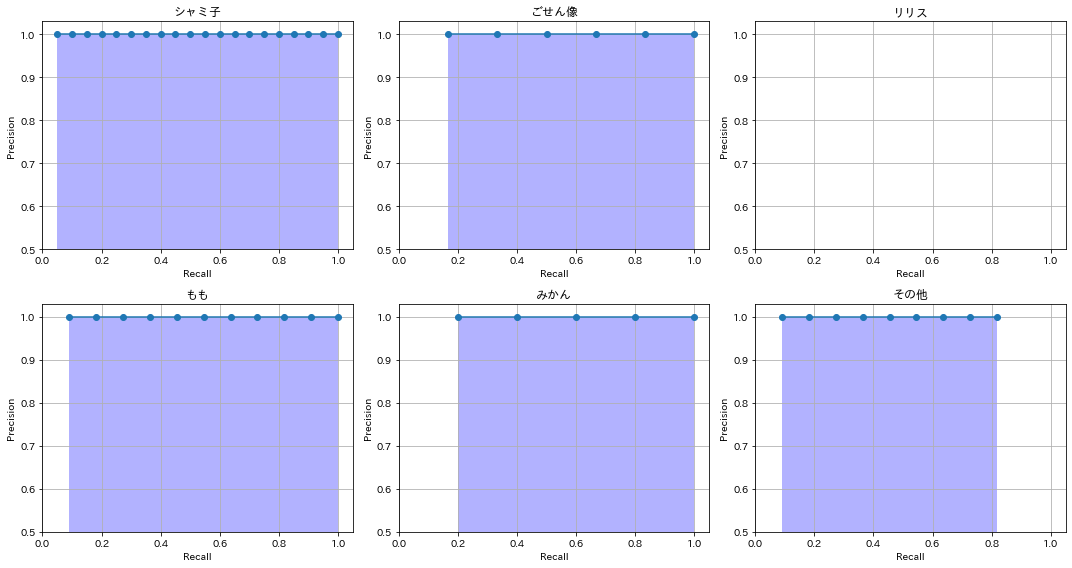

In [12]:
# プロット
plt.figure(figsize=(15, 8))

for i, _cls in enumerate(df_dict.keys()):
    df = df_dict[_cls]
    
    ax = plt.subplot(2, 3, i + 1)
    ax.plot(df['rec'], df['pre'], '-o')
    ax.fill_between(df['rec'], df['pre'], facecolor='b', alpha=0.3)
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0.5, 1.03])
    ax.grid(True)
    ax.set_title(CAT_NAME_JP[_cls])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
plt.tight_layout()
plt.show()

### AP, mAP の計算

mAP は 70.3%！！　前回は 40%弱 でしたから、水増しの効果があったようです。

* ご先祖様（リリス）は相変わらずです。データ数を増やせば違ってくるとは思うのですが、アノテーションが辛い・・・ｗ

In [13]:
from machikado_util.calc_ap import calc_AP

df = calc_AP(df_dict, cat_names=CAT_NAME_JP)
df = df.fillna(0)
df

,AP,iou
シャミ子,0.950000,0.878027
ごせん像,0.833333,0.821817
リリス,0.000000,0.000000
もも,0.909091,0.874551
みかん,0.800000,0.902283
その他,0.727273,0.866172


In [14]:
df.mean()

AP     0.703283
iou    0.723808
dtype: float64